Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Unit Scaling: A How-To Guide

In our paper [Unit Scaling: Out-of-the-Box Low-Precision Training](https://arxiv.org/abs/2303.11257), we describe a scheme for designing neural networks that have approximate unit variance after every operation in the forward and backward pass.

This can be seen as an alternative to (static) loss scaling, or its automatic variant, as used in Automatic Mixed Precision. Whereas both of those schemes rely on a single, global scaling factor for all the gradients, unit scaling is more fine-grained.

A unit-scaled model adds scaling factors (constant scalar multiplications) to each operation in the computational graph to achieve this unit variance property. The result is a model which naturally produces tensors in the middle of the dynamic range provided by floating-point formats. There's no extra loss-scale hyperparameter—it works out-of-the-box!

## Implementing a unit-scaled NanoGPT

Here we demonstrate how to go about unit scaling in practice. This involves re-implementing common neural network layers to add variance-preserving scaling factors.

As explained in the paper, we can sometimes justify using different scaling factors in the forward and backward pass. We introduce a special `scaled()` op which allows us to do just that.

Below we implement two models. The first is a simple implementation of a transformer-decoder. The design and hyperparameters are inspired by Andrej Karpathy's [popular NanoGPT implementation](https://github.com/karpathy/nanoGPT) (though some differ). It's also 🤗-compatible!

The second model is the same, but unit-scaled. Let's get stuck in...

_[hidden: pip installs and imports]_

In [ ]:
!pip install git+https://github.com/huggingface/optimum-graphcore.git
!pip install git+https://github.com/graphcore-research/poptorch-experimental-addons
!pip install altair

import math
from typing import Any, Callable, Dict, List, Optional, Tuple

import altair as alt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from transformers.activations import GELUActivation
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
from transformers.modeling_utils import PreTrainedModel

### The MLP layer

#### Regular scaling

We'll start by setting up a basic config for a reasonably small transformer:

_[hidden: misc. code to set up grad tracking, weight init, etc.]_

In [ ]:
np.seterr(divide="ignore")


def init_weights(init_fn: Callable[[int, int], float]) -> Callable[[nn.Module], None]:
    def inner_fn(module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            fan_out, fan_in = module.weight.shape
            module.weight.data.normal_(mean=0.0, std=init_fn(fan_in, fan_out))
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=1)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    return inner_fn


def instrument(module: nn.Module) -> Dict[str, Dict[str, float]]:
    stats: Dict[str, Dict[str, float]] = {}
    instrument_recursive(module, stats)
    return stats


def instrument_recursive(
    module: nn.Module, stats: Dict[str, Dict[str, float]], name: str = ""
) -> None:
    children = list(module.named_children())
    if children:
        for c_name, c in children:
            _name = f"{name}.{c_name}" if name and name != "blocks" else c_name
            instrument_recursive(c, stats, _name)
    else:
        instrument_terminal(module, stats, name)


def instrument_terminal(
    module: nn.Module, stats: Dict[str, Dict[str, float]], name: str = ""
) -> None:
    module_stats: Dict[str, float] = {}

    def require_input_grads(_module: nn.Module, input: Any) -> None:
        for i in input:
            if isinstance(i, Tensor) and i.is_floating_point():
                i.requires_grad_()

    module.register_forward_pre_hook(require_input_grads)

    if name.split(".")[-1] == "softmax":
        return

    def record_fwd_scale(_module: nn.Module, input: Any, output: Any) -> None:
        if isinstance(output, Tensor) and output.is_floating_point():
            module_stats["x"] = np.log2(output.std().item())

    module.register_forward_hook(record_fwd_scale)

    def record_bwd_scales(
        _module: nn.Module, grad_input: Any, grad_output: Any
    ) -> None:
        grad_input = list(grad_input)
        for g in grad_input:
            if (
                g is not None
                and isinstance(g, Tensor)
                and g.is_floating_point()
                and len(grad_input) == 1
            ):
                module_stats["grad_x"] = np.log2(g.std().item())

        for param_name, param in _module.named_parameters():
            if param_name == "weight":
                module_stats["w"] = np.log2(param.std().item())
                if param.grad is not None:
                    module_stats["grad_w"] = np.log2(param.grad.std().item())

    module.register_full_backward_hook(record_bwd_scales)

    stats[name] = module_stats


def visualise(stats: Dict[str, Dict[str, float]], subnormal: bool = False) -> None:
    df = pd.DataFrame(stats)
    df = df.stack().to_frame("scale (log₂)").reset_index(names=["type", "op"])
    plot(df, subnormal)


def plot(df: pd.DataFrame, subnormal: bool = False) -> None:
    is_x_or_grad_x = (df["type"] == "x") | (df["type"] == "grad_x")
    op_order = df[df["type"] == "x"]["op"].tolist()
    colors = ["#6C8EBF", "#FF8000", "#5D8944", "#ED3434"]
    x_range = np.arange(-18 if subnormal else -14, 18 + 1 if subnormal else 16 + 1, 2)

    fp16_min = alt.Chart().mark_rule(strokeDash=(4, 4)).encode(x=alt.datum(-14))
    fp16_min_text = (
        alt.Chart()
        .mark_text(dy=-740)
        .encode(text=alt.Text(value="Min FP16 (normal)"), x=alt.datum(-10))
    )
    fp16_max = alt.Chart().mark_rule(strokeDash=(4, 4)).encode(x=alt.datum(16))
    fp16_max_text = (
        alt.Chart()
        .mark_text(dy=-740)
        .encode(text=alt.Text(value="Max FP16"), x=alt.datum(13))
    )

    x_chart = (
        alt.Chart(df[is_x_or_grad_x])
        .mark_line()
        .encode(
            x=alt.X(
                "scale (log₂):Q",
                axis=alt.Axis(orient="top", values=x_range),
                scale=alt.Scale(domain=[x_range[0], x_range[-1]]),
            ),
            y=alt.Y("op:O", title="", sort=op_order),
            color=alt.Color(
                "type",
                legend=alt.Legend(title="", labelFontSize=12, symbolSize=100),
                scale=alt.Scale(range=colors[:2]),
                sort="descending",
            ),
        )
    )
    w_chart = (
        alt.Chart(df[~is_x_or_grad_x])
        .mark_point(size=100)
        .encode(
            x=alt.X(
                "scale (log₂):Q",
                axis=alt.Axis(orient="top", values=x_range),
                scale=alt.Scale(domain=[x_range[0], x_range[-1]]),
            ),
            y=alt.Y("op:O", title="", sort=op_order),
            color=alt.Color(
                "type",
                legend=alt.Legend(title="", labelFontSize=12, symbolSize=100),
                scale=alt.Scale(range=colors[2:]),
                sort="descending",
            ),
            shape=alt.Shape(
                "type",
                scale=alt.Scale(range=["square", "triangle-down"]),
                sort="descending",
            ),
        )
    )
    layers = [x_chart, w_chart]
    if subnormal:
        layers += [fp16_min, fp16_max, fp16_min_text, fp16_max_text]
    combined_chart = (
        alt.layer(*layers)
        .resolve_scale(color="independent", shape="independent")
        .configure_axis(labelFontSize=12, titleFontSize=16)
        .properties(width=500)
    )
    display(combined_chart)

In [ ]:
class NanoGPTConfig(PretrainedConfig):
    model_type = "nano-gpt"

    def __init__(
        self,
        hidden_size: int = 384,
        num_hidden_layers: int = 6,
        num_attention_heads: int = 6,
        dropout: float = 0.1,
        vocab_size: int = 384,
        eos_token_id: int = 1,
        **kwargs,
    ) -> None:
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.dropout = dropout
        self.vocab_size = vocab_size
        self.eos_token_id = eos_token_id
        super().__init__(**kwargs)

Along with a standard (pre-norm) MLP module:

In [ ]:
class MLP(nn.Module):
    def __init__(self, config: NanoGPTConfig) -> None:
        super().__init__()
        self.ln = nn.LayerNorm(config.hidden_size)
        self.linear_1 = nn.Linear(config.hidden_size, config.hidden_size * 4)
        self.act = GELUActivation()
        self.linear_2 = nn.Linear(config.hidden_size * 4, config.hidden_size)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, hidden_states: Tensor) -> Tensor:
        hidden_states = self.ln(hidden_states)
        hidden_states = self.linear_1(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.linear_2(hidden_states)
        return self.dropout(hidden_states)

Now we can analyse the scale (i.e. standard deviation) of each operation within the MLP. To do this, we provide an `instrument()` operation, which goes through and tracks the scale coming out of each operation in the forward and backward pass.

Our network's weights will also use the standard glorot initialisation.

Let's feed in a unit normal tensor in both directions, and examine the result.

In [ ]:
def analyse_mlp(
    mlp: MLP, config: NanoGPTConfig, batch_size: int = 64, seq_len: int = 16
) -> None:
    stats = instrument(mlp)
    x = torch.normal(0.0, 1.0, size=(batch_size, seq_len, config.hidden_size))
    y = mlp(x)
    y.backward(torch.normal(0.0, 1.0, size=y.shape))
    visualise(stats)

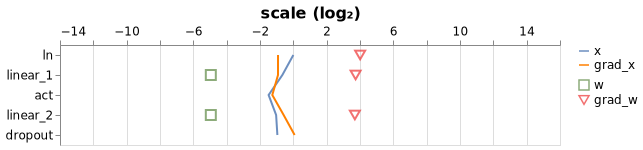

In [ ]:
def glorot_init(fan_in: int, fan_out: int) -> float:
    return ((fan_in + fan_out) / 2) ** -0.5

config = NanoGPTConfig()
mlp = MLP(config).apply(init_weights(glorot_init))
analyse_mlp(mlp, config)

> **How to interpret this chart:** The x-axis shows the scale in $\log_2$ form. The range here represents the minimum and maximum absolute values that can be represented in the FP16 or FP8 E5 number formats (excluding subnormal values). In other words, if the scale exceeds the x-axis bounds we're in the numerics "danger zone" where training begins to degrade.
>
> The y-axis shows the operations in the model, in the order in which they execute. We show the scale of activations (x), gradients (grad_x, grad_w) and weights (w). Activations can be said to "flow" forward through these layers, and grad_xs flow backwards, so we represent these by solid lines, and weights and grad_ws by symbols.

By the end of both passes the x and grad_x scales have dropped by half. This is due to glorot slightly under-scaling values, and GeLU dropping the scale further.

Worse, the weights are significantly under-scaled and the grad_ws over-scaled by a factor of $2^4$. This is largely because glorot scaling (along with all other weight init schemes) only accounts for the forward and grad_x scales.

#### Unit scaling

We'll now implement the equivalent layer using unit scaling. First we must define our scaling operation (enabling different scales in the forward and backward pass).

In [ ]:
class ScaledGrad(torch.autograd.Function):
    @staticmethod
    def forward(
        ctx: torch.autograd.function.FunctionCtx, X: Tensor, alpha: float, beta: float
    ) -> Tensor:
        ctx.save_for_backward(torch.tensor(beta, dtype=X.dtype))
        return alpha * X

    @staticmethod
    def backward(
        ctx: torch.autograd.function.FunctionCtx, grad_Y: Tensor
    ) -> Tuple[Tensor, None, None]:
        (beta,) = ctx.saved_tensors
        return beta * grad_Y, None, None


def scaled(X: Tensor, alpha: float = 1.0, beta: float = 1.0) -> Tensor:
    # Forward: Y = X * alpha
    # Backward: grad_X = grad_Y * beta
    return ScaledGrad.apply(X, alpha, beta)


def geometric_mean(xs: List[float]) -> float:
    xs = np.array(xs)
    return xs.prod() ** (1 / xs.size)

Now we can implement our first unit-scaled layer, a basic linear module:

In [ ]:
class UnitScaledLinear(nn.Linear):
    def __init__(self, *args, scale_for: str = "fwd, grad_x", **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.scale_for = scale_for

    def get_scales(self, input: Tensor) -> Tuple[float, float, float]:
        fwd_scale = self.weight.shape[1] ** -0.5
        grad_x_scale = self.weight.shape[0] ** -0.5
        grad_w_scale = np.prod(input.shape[:-1]) ** -0.5
        if self.scale_for == "fwd":
            grad_x_scale = fwd_scale
        elif self.scale_for == "grad_x":
            fwd_scale = grad_x_scale
        elif self.scale_for == "fwd, grad_x":
            fwd_scale = grad_x_scale = geometric_mean([fwd_scale, grad_x_scale])
        else:
            assert (
                self.scale_for == "separate"
            ), f"demo implementation has no {self.scale_for} scaling"
        return fwd_scale, grad_x_scale, grad_w_scale

    def forward(self, input: Tensor) -> Tensor:
        fwd_scale, grad_x_scale, grad_w_scale = self.get_scales(input)
        input = scaled(input, beta=grad_x_scale)
        weight = scaled(self.weight, beta=grad_w_scale)
        bias = scaled(self.bias, beta=grad_w_scale) if self.bias is not None else None
        output = F.linear(input, weight, bias)
        return scaled(output, alpha=fwd_scale)

Let's break this down a bit. The `forward()` method is still based on the fundamental `F.linear(input, weight, bias)` operation, but has each of its operands and output scaled.

This is done via the `scaled(X, alpha, beta)` method. This is a special operation in that it has different dynamics in the forward and backward pass, where we have

$$Y = X \cdot \alpha$$

$$\nabla_X = \nabla_Y \cdot \beta$$

So what scaling factors do we choose? This is determined in `get_scales()`. The standard approach is to set the forward and grad_x scales as a compromise between their "ideal" scale-preserving values (via a geometric mean). See our paper for more details on how we arrive at these ideal values.

We also provide versions of the operation which select forward and grad_x scales based on only one of their ideal values. We also have a scheme which has separate forward and grad_x scales, though this is only allowed in special circumstances (again, see the paper).

Now for the GeLU. This is pretty similar to the linear op. However, as activation functions are nonlinear, our usual approach of calculating scaling values analytically (i.e. by working through the maths) isn't always possible.

Fortunately, for these elemenwise ops we can calulate them empirically, like so:

In [ ]:
def analyse_elemenwise_fn(
    fn: Callable[[Tensor], Tensor], num_samples: int = 2**22
) -> None:
    x = torch.normal(0.0, 1.0, size=(num_samples,)).requires_grad_()
    y = fn(x)
    y.backward(torch.normal(0.0, 1.0, size=(num_samples,)))
    print(f"fwd scale={y.std():.3f}, bwd scale={x.grad.std():.3f}")


print("GeLU:", end=" ")
analyse_elemenwise_fn(GELUActivation())
print("Tanh:", end=" ")
analyse_elemenwise_fn(nn.Tanh())

GeLU: fwd scale=0.588, bwd scale=0.675
Tanh: fwd scale=0.628, bwd scale=0.682


We then put these scaling factors into our unit-scaled op as follows:

In [ ]:
class UnitScaledGELU(GELUActivation):
    def forward(self, input: Tensor) -> Tensor:
        fwd_scale = bwd_scale = geometric_mean([0.588, 0.675]) ** -1
        input = scaled(input, beta=bwd_scale)
        output = self.act(input)
        return scaled(output, alpha=fwd_scale)

Simple! Now we just need to unit scale the layernorm and dropout and we're ready.

These take the same kind of approach, so we won't go into too much detail here:

In [ ]:
class UnitScaledLayerNorm(nn.LayerNorm):
    def forward(self, input: Tensor) -> Tensor:
        scale = (np.prod(self.normalized_shape) / input.nelement()) ** 0.5
        weight = scaled(self.weight, beta=scale)
        bias = scaled(self.bias, beta=scale)
        return F.layer_norm(input, self.normalized_shape, weight, bias, self.eps)


class UnitScaledDropout(nn.Dropout):
    def forward(self, input: Tensor) -> Tensor:
        # Dropout is typically implemented with a (1-p) ** -1 scaling
        # However, to preserve variance this ought to be (1-p) ** -0.5
        # We correct for this by multiplying by (1-p) ** 0.5
        scale = (1 - self.p) ** 0.5
        input = scaled(input, beta=scale)
        output = F.dropout(input, self.p, self.training, self.inplace)
        return scaled(output, alpha=scale)

We're now ready to unit-scale the full MLP 🥳

All this requires is swapping out the old layers for our new ones:

In [ ]:
class UnitScaledMLP(MLP):
    def __init__(self, config: NanoGPTConfig) -> None:
        super().__init__(config)
        self.ln = UnitScaledLayerNorm(config.hidden_size)
        self.linear_1 = UnitScaledLinear(config.hidden_size, config.hidden_size * 4)
        self.act = UnitScaledGELU()
        self.linear_2 = UnitScaledLinear(config.hidden_size * 4, config.hidden_size)
        self.dropout = UnitScaledDropout(config.dropout)

We also change our initialisation to give our weights unit scale. Let's analyse our new unit-scaled MLP:

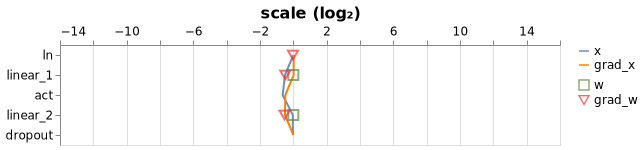

In [ ]:
def unit_init(*args) -> float:
    return 1.0


mlp = UnitScaledMLP(config).apply(init_weights(unit_init))
analyse_mlp(mlp, config)

This is much better! The final scales are almost exactly 1 in both directions, and weights and grad_ws look much better.

The compromise fwd & grad_x scaling factors in our linear layers do give temporary non-unit scaling, but this is minor and the second linear layer cancels out the first.

### The self-attention layer

#### Regular scaling

We start with a basic implementation of a (self-)attention module.

(Note that we use [ALiBi](https://arxiv.org/abs/2108.12409) biases over positional embeddings here. This is primarily for simplicity, though these have also been [shown to perform](https://arxiv.org/abs/2210.15424) remarkably well!)

_[hidden: helper self-attention methods]_

In [ ]:
class Matmul(nn.Module):
    def forward(self, a: Tensor, b: Tensor, scale: float = 1.0) -> Tensor:
        return (a @ b) * scale


def split_heads(tensor: Tensor, num_heads: int, head_size: int) -> Tensor:
    batch_size, seq_len, hidden_size = tensor.shape
    tensor = tensor.view(batch_size, seq_len, num_heads, head_size)
    return tensor.permute(0, 2, 1, 3)


def merge_heads(tensor: Tensor, num_heads: int) -> Tensor:
    tensor = tensor.permute(0, 2, 1, 3).contiguous()
    batch_size, seq_len, num_heads, head_size = tensor.shape
    return tensor.view(batch_size, seq_len, num_heads * head_size)


def causal_mask(seq_len: int, num_heads: int) -> Tensor:
    causal_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.float16))
    causal_mask = causal_mask.view(1, 1, seq_len, seq_len)
    alibi_mask = gen_alibi_mask(causal_mask, num_heads)
    causal_mask = (1.0 - causal_mask) * -10_000
    return alibi_mask + causal_mask


# Based on https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/transformers/alibi/__init__.py
def gen_alibi_mask(causal_mask: Tensor, num_heads: int) -> Tensor:
    distances = causal_mask.to(torch.float32).cumsum(dim=-1)
    slopes = gen_slopes(num_heads)
    return distances.to(torch.float16) * slopes.view(1, num_heads, 1, 1)


def gen_slopes(num_heads: int) -> Tensor:
    n = 2 ** math.floor(math.log2(num_heads))
    m_0 = 2.0 ** (-8.0 / n)
    m = torch.pow(m_0, torch.arange(1, 1 + n))
    if n < num_heads:
        m_hat_0 = 2.0 ** (-4.0 / n)
        m_hat = torch.pow(m_hat_0, torch.arange(1, 1 + 2 * (num_heads - n), 2))
        m = torch.cat([m, m_hat])
    return m

In [ ]:
class Attention(nn.Module):
    def __init__(self, config: NanoGPTConfig) -> None:
        super().__init__()
        self.ln = nn.LayerNorm(config.hidden_size)
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads

        self.w_qkv = nn.Linear(config.hidden_size, 3 * config.hidden_size)
        self.qk_matmul = Matmul()
        self.softmax = nn.Softmax(-1)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.qkv_matmul = Matmul()
        self.w_o = nn.Linear(config.hidden_size, config.hidden_size)
        self.residual_dropout = nn.Dropout(config.dropout)

    def forward(self, hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        seq_len = hidden_states.shape[1]
        head_size = self.hidden_size // self.num_heads

        hidden_states = self.ln(hidden_states)
        q_k_v = self.w_qkv(hidden_states)
        q, k, v = q_k_v.split(self.hidden_size, dim=-1)
        q, k, v = (split_heads(t, self.num_heads, head_size) for t in (q, k, v))

        qk = self.qk_matmul(q, k.transpose(-1, -2), scale=1 / head_size**0.5).clone()
        qk += causal_mask(seq_len, self.num_heads) + attention_mask
        qk = self.softmax(qk)
        qk = self.attn_dropout(qk)

        qkv = self.qkv_matmul(qk, v)
        qkv = merge_heads(qkv, self.num_heads)
        qkvo = self.w_o(qkv)
        return self.residual_dropout(qkvo).clone()

In [ ]:
def analyse_attn(
    attention: Attention, config: NanoGPTConfig, batch_size: int = 64, seq_len: int = 16
) -> None:
    stats = instrument(attention)
    x = torch.normal(0.0, 1.0, size=(batch_size, seq_len, config.hidden_size))
    attention_mask = torch.zeros(batch_size, 1, 1, seq_len)
    y = attention(x, attention_mask)
    y.backward(torch.normal(0.0, 1.0, size=y.shape))
    visualise(stats)

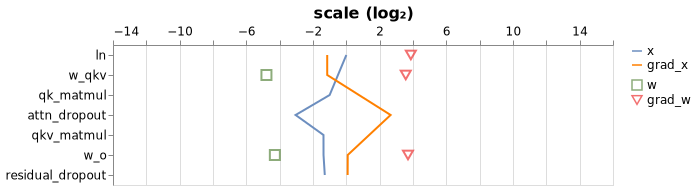

In [ ]:
attention = Attention(config).apply(init_weights(glorot_init))
analyse_attn(attention, config)

Again here, the activation scales and grad_x scales fall by half as they go through the layer, and fluctuate in between (Note that we omit the softmax operation here as a) its output isn't normally distributed, and b) we usually do it in higher-precision anyway). We see the same problems as before for weights and grad_ws.

Let's fix this:

#### Unit scaling

In [ ]:
class UnitScaledAttention(Attention):
    def __init__(self, config: NanoGPTConfig) -> None:
        super().__init__(config)
        self.ln = UnitScaledLayerNorm(config.hidden_size)
        self.w_qkv = UnitScaledLinear(
            config.hidden_size, 3 * config.hidden_size, scale_for="fwd"
        )
        self.qk_matmul = UnitScaledMatmul(scale_for="fwd")
        self.softmax = UnitScaledSoftmax(-1)
        self.attn_dropout = UnitScaledDropout(config.dropout)
        self.qkv_matmul = UnitScaledMatmul(scale_for="fwd")
        self.w_o = UnitScaledLinear(config.hidden_size, config.hidden_size)
        self.residual_dropout = UnitScaledDropout(config.dropout)


class UnitScaledMatmul(Matmul):
    def __init__(self, scale_for: str = "fwd, grad_a, grad_b") -> None:
        super().__init__()
        self.scale_for = scale_for

    def get_scales(self, a: Tensor, b: Tensor) -> Tuple[float, float, float]:
        fwd_scale = a.shape[-1] ** -0.5
        grad_a_scale = b.shape[-1] ** -0.5
        grad_b_scale = a.shape[-2] ** -0.5
        if self.scale_for == "fwd":
            grad_a_scale = grad_b_scale = fwd_scale
        elif self.scale_for == "fwd, grad_a, grad_b":
            fwd_scale = grad_a_scale = grad_b_scale = geometric_mean(
                [fwd_scale, grad_a_scale, grad_b_scale]
            )
        else:
            assert False, f"demo implementation has no {self.scale_for} scaling"
        return fwd_scale, grad_a_scale, grad_b_scale

    def forward(self, a: Tensor, b: Tensor, scale: float = 1.0) -> Tensor:
        # ignores provided scale
        fwd_scale, grad_a_scale, grad_b_scale = self.get_scales(a, b)
        a = scaled(a, beta=grad_a_scale)
        b = scaled(b, beta=grad_b_scale)
        output = a @ b
        return scaled(output, alpha=fwd_scale)


class UnitScaledSoftmax(nn.Softmax):
    def forward(self, input: Tensor) -> Tensor:
        fwd_scale = bwd_scale = input.shape[-1] ** 0.5
        input = scaled(input, fwd_scale)
        output = F.softmax(input, self.dim, _stacklevel=5)
        return scaled(output, bwd_scale)

To unit scale the attention layer we again swap out regular layers for unit-scaled ones. This requires altering two more operations: matmul and softmax.

Like the linear layer, we provide scaling the matmul based on varying criteria. We find that scaling each matmul and linear layer here for the forward pass ensures good scaling in both directions. We see this empirically in our analysis:

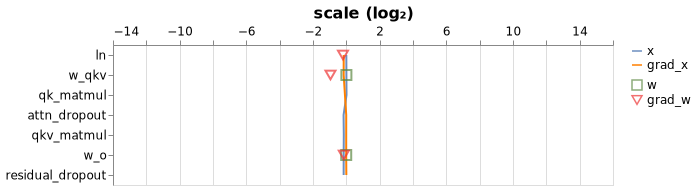

In [ ]:
attention = UnitScaledAttention(config).apply(init_weights(unit_init))
analyse_attn(attention, config, batch_size=64, seq_len=64)

Again, a great improvement for all four types of tensors, with each having approximate unit scale. Note that these scaling rules are robust to changes in hyperparameters too. You can experiment with the initial config to verify this.

We now have our key building-blocks 🧱 Let's put it all together!

### The transformer block

#### Regular scaling

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, config: NanoGPTConfig) -> None:
        super().__init__()
        self.attention_layer = Residual(Attention(config))
        self.mlp_layer = Residual(MLP(config))

    def forward(self, hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        hidden_states = self.attention_layer(hidden_states, attention_mask)
        return self.mlp_layer(hidden_states)


class Residual(nn.Module):
    def __init__(self, f: nn.Module) -> None:
        super().__init__()
        self.f = f

    def forward(self, x: Tensor, *args) -> Tensor:
        return x + self.f(x, *args)

#### Unit scaling

In [ ]:
class UnitScaledTransformerBlock(TransformerBlock):
    def __init__(self, config: NanoGPTConfig) -> None:
        super().__init__(config)
        self.attention_layer = UnitScaledResidual(UnitScaledAttention(config))
        self.mlp_layer = UnitScaledResidual(UnitScaledMLP(config))


class UnitScaledResidual(Residual):
    def __init__(self, f: nn.Module, tau: float = 0.2) -> None:
        super().__init__(f)
        self.tau = tau

    def forward(self, x: Tensor, *args) -> Tensor:
        y = x * (1 - self.tau) ** 0.5
        z = scaled(x, beta=self.tau**0.5)
        z = self.f(z, *args)
        z = scaled(z, alpha=self.tau**0.5)
        return y + z

Note that the scaling in our residual layer includes an important trick.

It's necessary for unit-scaled models to use a weighted sum when doing their residual-add, to down-weight the residual/trunk branch. If this is not included, training can fail as too much signal comes from each residual (regular models avoid this as their residual implicitly reduces scale).

However, the naïve implementation of this breaks unit scale. We get around this by delaying the weighting until the end of the residual branch in the backward pass (see paper for more details).

### The full transformer

#### Regular scaling

Note that our implementation contains a little extra boilerplate to make it 🤗-compliant.

In [ ]:
class NanoGPTModel(PreTrainedModel):
    config_class = NanoGPTConfig

    def __init__(self, config: NanoGPTConfig) -> None:
        super().__init__(config)
        self.input_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.dropout = nn.Dropout(config.dropout)
        self.ln = nn.LayerNorm(config.hidden_size)
        self.blocks = nn.ModuleList(
            [TransformerBlock(config) for _ in range(config.num_hidden_layers)]
        )
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        self.loss_fn = nn.CrossEntropyLoss()
        self.apply(init_weights(glorot_init))

    def forward(
        self,
        input_ids: Tensor,
        attention_mask: Tensor,
        position_ids: Optional[Tensor] = None,
        labels: Optional[Tensor] = None,
        **kwargs,
    ) -> CausalLMOutputWithCrossAttentions:
        attention_mask = attention_mask[:, None, None, :].to(dtype=self.dtype)
        attention_mask = (1.0 - attention_mask) * -10_000

        hidden_states = self.input_embeddings(input_ids)
        hidden_states = self.dropout(hidden_states)
        for block in self.blocks:
            hidden_states = block(hidden_states, attention_mask=attention_mask)
        hidden_states = self.ln(hidden_states)
        logits = self.lm_head(hidden_states)

        if labels is None:
            return CausalLMOutputWithCrossAttentions(logits=logits)
        else:
            labels = torch.roll(labels, -1, 1)
            labels[:, -1] = -100  # By default, ignore_index of CrossEntropyLoss is -100
            loss = self.loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
            return CausalLMOutputWithCrossAttentions(loss=loss)

    def get_input_embeddings(self) -> nn.Embedding:
        return self.input_embeddings

    def prepare_inputs_for_generation(
        self, input_ids: Tensor, **kwargs
    ) -> Dict[str, Tensor]:
        attention_mask = kwargs["attention_mask"]
        position_ids = attention_mask.long().cumsum(-1) - 1
        position_ids.masked_fill_(attention_mask == 0, 1)
        return {
            "input_ids": input_ids,
            "position_ids": position_ids,
            "attention_mask": attention_mask,
        }

In [ ]:
def analyse_full_model(
    model: nn.Module, config: NanoGPTConfig, batch_size: int = 64, seq_len: int = 16
) -> None:
    stats = instrument(model)
    input_ids = labels = torch.randint(0, config.vocab_size, size=(batch_size, seq_len))
    attention_mask = torch.zeros(batch_size, seq_len)
    y = model(input_ids, attention_mask, labels=labels).loss
    y.backward()
    visualise(stats, subnormal=True)

Here's the scaling for the entire (non-unit-scaled) transformer:

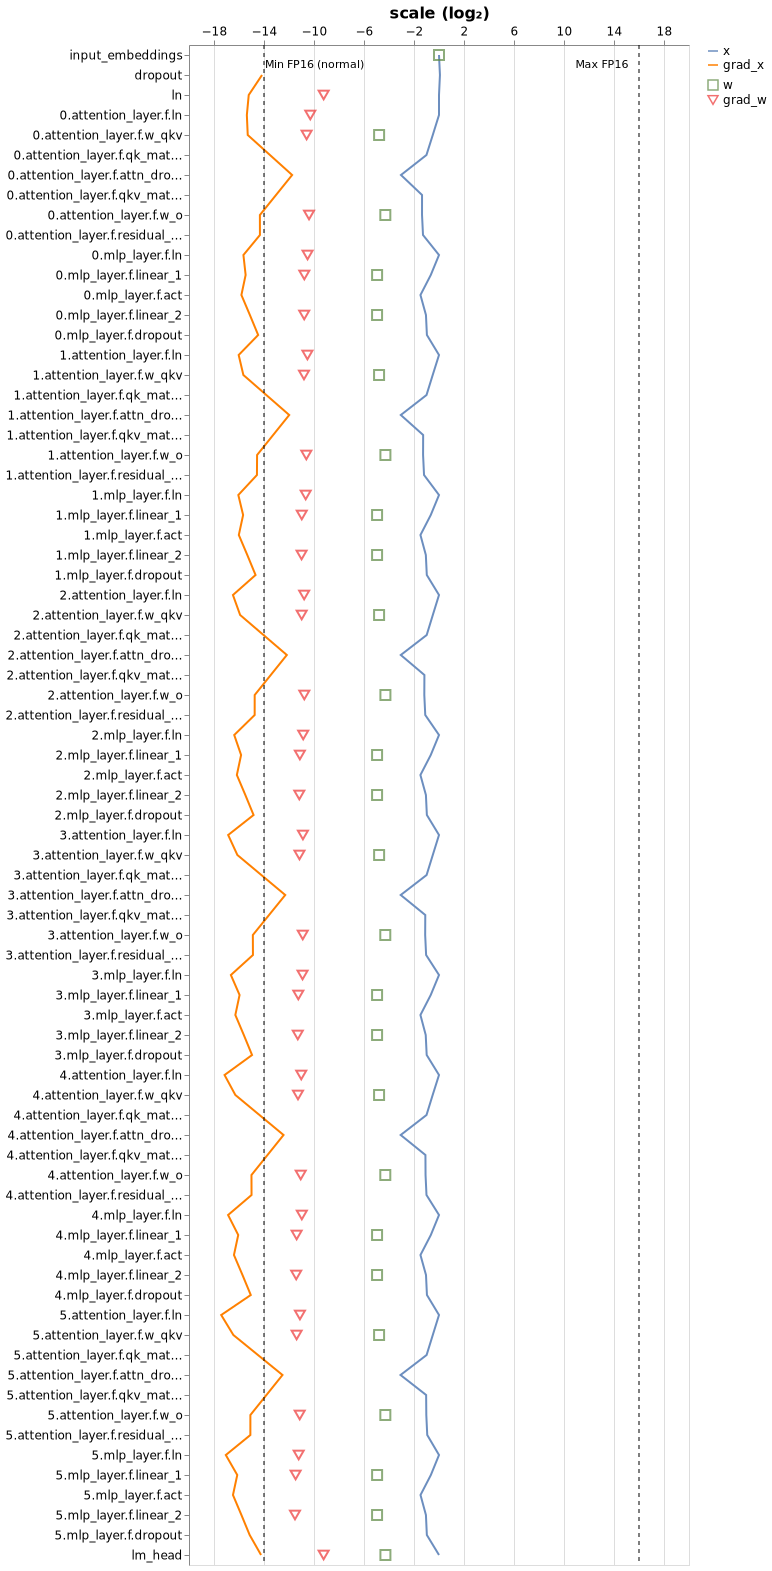

In [ ]:
model = NanoGPTModel(config)
analyse_full_model(model, config)

These results clearly demonstrates the inadiquacy of the standard approach to model design when it comes to scale. Grad_x and grad_w values are very far from having unit scale, with the former now relying on subnormal values (dangerous, as these begin to lose precision and disappear altogether at $2^{-24}$).

A key issue introduced by this layer is the cross-entropy loss definition. This typically uses a `1 / batch_size` term to average over labels, which has the effect of dramatically under-scaling gradients in the backward pass.

We can also see here that a single loss scaling factor for all gradients isn't ideal. This would shift all grad_xs and grad_ws to the right by the same amount, which would still leave us far short of our unit-scale ideal.

What we really need is per-op scaling! Again, we'll fix this for the unit-scaled implementation:

#### Unit scaling

In [ ]:
class UnitScaledNanoGPTModel(NanoGPTModel):
    config_class = NanoGPTConfig

    def __init__(self, config: NanoGPTConfig) -> None:
        super().__init__(config)
        self.input_embeddings = UnitScaledEmbedding(
            config.vocab_size, config.hidden_size
        )
        self.dropout = UnitScaledDropout(config.dropout)
        self.ln = UnitScaledLayerNorm(config.hidden_size)
        self.blocks = nn.ModuleList(
            [
                UnitScaledTransformerBlock(config)
                for _ in range(config.num_hidden_layers)
            ]
        )
        self.lm_head = UnitScaledLinear(
            config.hidden_size, config.vocab_size, bias=False, scale_for="separate"
        )
        self.loss_fn = UnitScaledCrossEntropyLoss()
        self.apply(init_weights(unit_init))


class UnitScaledEmbedding(nn.Embedding):
    def forward(self, input: Tensor) -> Tensor:
        batch_size = np.prod(input.shape)
        weight = scaled(self.weight, beta=self.num_embeddings / batch_size)
        return F.embedding(
            input,
            weight,
            self.padding_idx,
            self.max_norm,
            self.norm_type,
            self.scale_grad_by_freq,
            self.sparse,
        )


class UnitScaledCrossEntropyLoss(nn.CrossEntropyLoss):
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        batch_size, seq_len = input.shape
        input = scaled(input, beta=seq_len / (seq_len - 1) ** 0.5)
        loss = F.cross_entropy(input, target, reduction="sum")
        return scaled(loss, alpha=1 / batch_size)

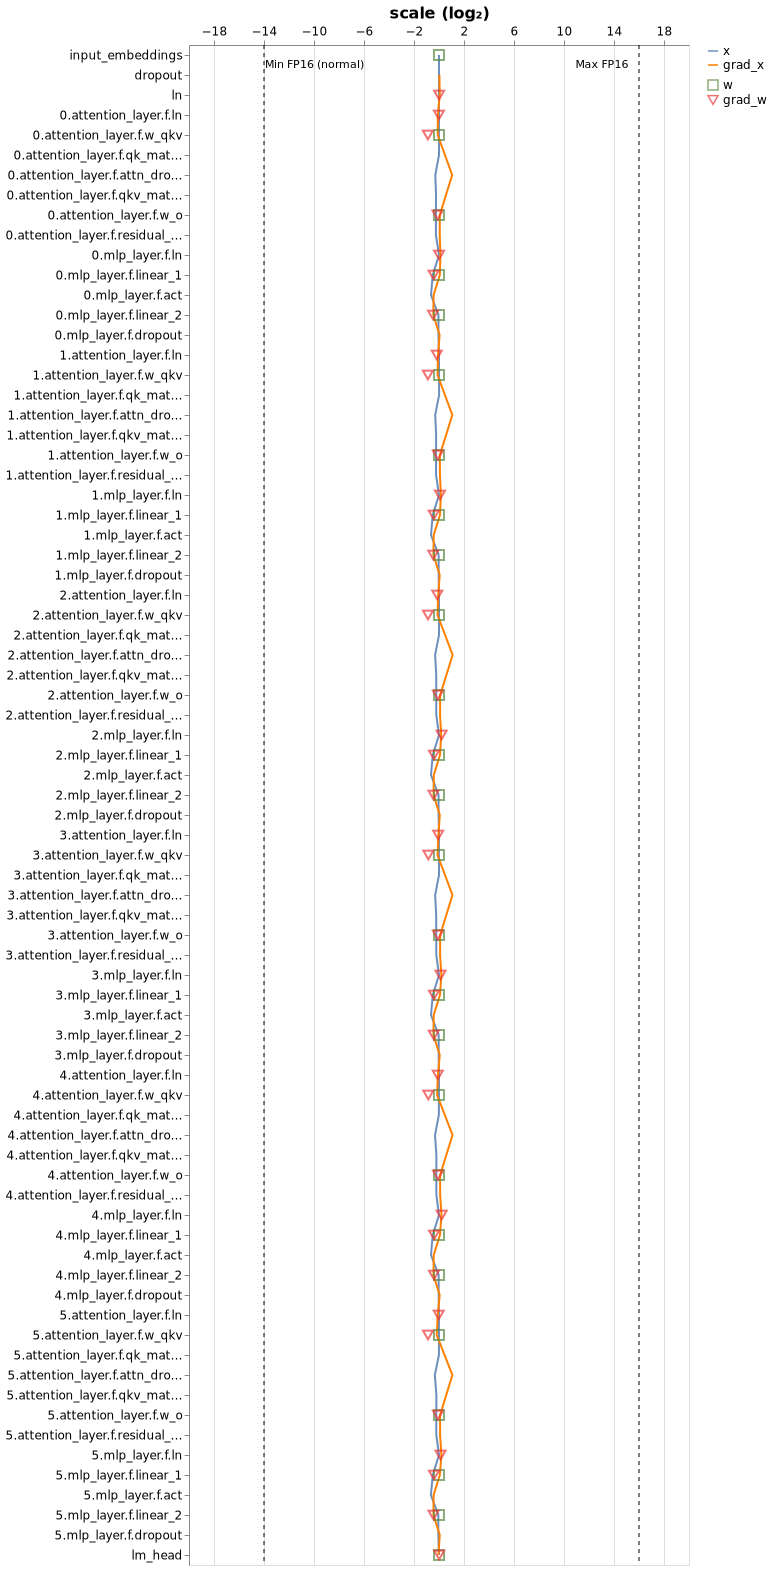

In [ ]:
model = UnitScaledNanoGPTModel(config)
analyse_full_model(model, config)

Success! 🥂 🎊 🍾 We've managed to keep every tensor in the model at unit scale for the forward and backward pass. All that was required was to re-implement standard layers with the right scaling factors.

Of course, this only gives us the right scaling *at initialisation*. Scales inevitably drift throughout training, but we've given ourselves headroom by starting in the ideal place. The results in our paper show that this is sufficient to enable accurate, out-the-box training of many models, up to the size of BERT Large (we haven't tested anything larger—yet!).

## Training

Having implemented our model, lets train it using the 🤗 library:

_[hidden: IPU training setup]_

In [ ]:
from functools import partial

import poptorch_experimental_addons as pea
from datasets.load import load_dataset
from optimum.graphcore import (
    IPUConfig,
    IPUTrainer,
    IPUTrainingArguments,
    pipeline,
    pipelines,
)
from optimum.graphcore.generation_utils import IPUGenerationMixin
from optimum.graphcore.modeling_utils import (
    PipelineMixin,
    outline_attribute,
    register,
    tied_weight_model,
)
from transformers import AutoTokenizer, DataCollatorForLanguageModeling


@tied_weight_model(NanoGPTModel)
@register(NanoGPTModel)
class PipelinedNanoGPTModel(NanoGPTModel, PipelineMixin, IPUGenerationMixin):
    def parallelize(self) -> None:
        self._hooks = [outline_attribute(self.ln, "LayerNorm")]

    def deparallelize(self) -> None:
        pass


@tied_weight_model(UnitScaledNanoGPTModel)
@register(UnitScaledNanoGPTModel)
class PipelinedUnitScaledNanoGPTModel(
    UnitScaledNanoGPTModel, PipelineMixin, IPUGenerationMixin
):
    def parallelize(self) -> None:
        self._hooks = [outline_attribute(self.ln, "UnitScaledLayerNorm")]

    def deparallelize(self) -> None:
        pass


def scaled(X: Tensor, alpha: float = 1.0, beta: float = 1.0) -> Tensor:
    # Forward: Y = X * alpha
    # Backward: grad_X = grad_Y * beta
    return pea.autograd_proxy(X * alpha, X * beta)

#### Regular scaling

To show that this really does work, let's train both our models.

As in Karpathy's original NanoGPT, we'll train on the small Shakespeare dataset for a few minutes and see if we can get something that captures the rough style. Starting with the regular (non-unit-scaled) model:

In [ ]:
dataset = load_dataset("tiny_shakespeare")
tokenizer = AutoTokenizer.from_pretrained("google/byt5-small")

config = NanoGPTConfig(vocab_size=len(tokenizer), eos_token_id=tokenizer.eos_token_id)
batch_sz = 16
seq_len = 128
ipu_config = IPUConfig(
    gradient_accumulation_steps=5 * 64 // batch_sz,
    layers_per_ipu=[config.num_hidden_layers],
    executable_cache_dir="./exe_cache",
)


def split_and_tokenize(
    data: Dict[str, Any], seq_len: int, batch_sz: int
) -> Dict[str, Any]:
    tokens = tokenizer(data["text"])
    seqs = [
        tokens["input_ids"][0][i : i + seq_len]
        for i in range(0, len(tokens["input_ids"][0]), seq_len)
    ]
    seqs = seqs[: int(len(seqs) / batch_sz) * batch_sz]  # make divisible by batch size
    return {"input_ids": seqs}


prep_data = partial(split_and_tokenize, seq_len=seq_len, batch_sz=batch_sz)
tokenized_dataset = dataset.map(
    prep_data, batched=True, remove_columns=dataset["train"].column_names
)

In [ ]:
train_args = IPUTrainingArguments(
    output_dir="out",
    per_device_train_batch_size=batch_sz,
    per_device_eval_batch_size=batch_sz,
    evaluation_strategy="steps",
    eval_steps=250,
    logging_steps=20,
    max_steps=1000,
    weight_decay=0.1,
    warmup_steps=100,
    lr_scheduler_type="linear",
    learning_rate=1e-3,
    loss_scaling=2**6,
)

model = NanoGPTModel(config)

trainer = IPUTrainer(
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    model=model,
    args=train_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    ipu_config=ipu_config,
)

trainer.train()
trainer.save_model("trained_model/")



Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 1000/1000 [03:08<00:00,  5.31it/s]
Saving model checkpoint to trained_model/
Configuration saved in trained_model/ipu_config.json


{'train_runtime': 188.3129, 'train_samples_per_second': 1699.3, 'train_steps_per_second': 5.31, 'train_loss': 1.6398095703125, 'epoch': 41.67}


{'eval_loss': 1.5078125, 'eval_runtime': 0.4775, 'eval_samples_per_second': 904.799, 'eval_steps_per_second': 56.55, 'epoch': 41.67}


Note that we use loss scaling here, though this model is sufficiently small that it can get away without loss scaling. This certainly doesn't hold for larger models though.

To really get a sense of how the model's doing, we ought to get it to write some Shakespeare. Here's two attempts at *The Tempest*:

In [ ]:
pipelines.check_model_type = lambda self, supported_models: ...

final_model = NanoGPTModel.from_pretrained("trained_model/")

TEST_INPUT = """PROSPERO:
Our revels now are ended. These our actors,
As I foretold you, were all spirits"""
pipe = pipeline(
    "text-generation",
    ipu_config=ipu_config.to_dict(),
    model=final_model,
    tokenizer=tokenizer,
    max_length=512,
    do_sample=True,
)

outputs = pipe(TEST_INPUT, num_return_sequences=2, temperature=0.4)
for i, output in enumerate(outputs):
    print(f"\n===== Completion [{i+1}] =====\n")
    print(output["generated_text"])


===== Completion [1] =====

PROSPERO:
Our revels now are ended. These our actors,
As I foretold you, were all spirits him
And here is a part to the scorns of him.

BRUTUS:
Well, here's a very foul of the house to the common
To be secret the trumpets of the people's revenge,
That he presently presence.

CORIOLANUS:
The gods of the slanders of the children of the world
The consuls of the cause of the love.

POLIXENES:
The gods and Capulet, good Camillo's such as as the
That resign as her for the country.

BUCKINGHAM:
So shall be the sta

===== Completion [2] =====

PROSPERO:
Our revels now are ended. These our actors,
As I foretold you, were all spirits in the state.

DUKE OF YORK:
I have stay a fair is the strew and parts the fair
And therefore I would not the people.

GLOUCESTER:
The king is the heads of a king, and like thee
Will be proud in the seasons of your father.

KING RICHARD III:
Why, then, then, the heavens it was a state?

LADY ANNE:
Why, what says the hath the prince of th

It's not going to win any literary awards, but pretty good for a few minutes of training. Now let's see if our unit-scaled model can do the same...

#### Unit scaling

All we need to do is swap in our new model, remove the loss scaling (of course!), and increase the learning rate (as our weights are now larger due to unit-initialisation).

_[hidden: IPU unit scaling setup]_

In [ ]:
class _IPUConfig(IPUConfig):
    def to_options(self, *args, **kwargs):
        options = super().to_options(*args, **kwargs)
        options._popart.setPatterns(dict(AutogradProxyOpPattern=True))
        return options

    def for_pod_type(self, *args, **kwargs):
        config = super().for_pod_type(*args, **kwargs)
        config.__class__ = _IPUConfig
        return config


ipu_config.__class__ = _IPUConfig

In [ ]:
model = UnitScaledNanoGPTModel(config)

train_args.loss_scaling = 1.0
train_args.learning_rate = 2e-2

unit_scale_trainer = IPUTrainer(
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    model=model,
    args=train_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    ipu_config=ipu_config,
)

unit_scale_trainer.train()
unit_scale_trainer.save_model("trained_model/")



Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 1000/1000 [04:03<00:00,  4.10it/s]
Saving model checkpoint to trained_model/
Configuration saved in trained_model/ipu_config.json


{'train_runtime': 243.6652, 'train_samples_per_second': 1313.277, 'train_steps_per_second': 4.104, 'train_loss': 1.632796875, 'epoch': 41.67}
{'eval_loss': 1.466796875, 'eval_runtime': 0.7101, 'eval_samples_per_second': 608.345, 'eval_steps_per_second': 38.022, 'epoch': 41.67}


We get a similar evaluation loss as the regular model—a success! In fact after sweeping the learning rate, unit scaling appears to be slightly better here.

Let's celebrate with some unit-scaled Shakespeare...

In [ ]:
pipelines.check_model_type = lambda self, supported_models: ...

final_model = UnitScaledNanoGPTModel.from_pretrained("trained_model/")


TEST_INPUT = """PROSPERO:
Our revels now are ended. These our actors,
As I foretold you, were all spirits"""
pipe = pipeline(
    "text-generation",
    ipu_config=ipu_config.to_dict(),
    model=final_model,
    tokenizer=tokenizer,
    max_length=512,
    do_sample=True,
)

outputs = pipe(TEST_INPUT, num_return_sequences=2, temperature=0.4)
for i, output in enumerate(outputs):
    print(f"\n===== Completion [{i+1}] =====\n")
    print(output["generated_text"])


===== Completion [1] =====

PROSPERO:
Our revels now are ended. These our actors,
As I foretold you, were all spirits of the
provost: the strength of your honours and strength
To meet the world in the violence of your father's country's life
Than the ground of the court-wings of all the death.

KING HENRY VI:
My lord, the last is the father for the court?

KING RICHARD III:
No more than I see thee to be a peace
And more than my brother's love in the gods
And the root of my counsel: therefore I mean not
The sister of the charge of the 

===== Completion [2] =====

PROSPERO:
Our revels now are ended. These our actors,
As I foretold you, were all spirits for the head
To see him that live and dear at his country's head,
The sea of his crown, sir, the last of the ground
Of our highness and the sun of his presence
Of the singer of the steed service of her sense,
That she was not her of your grace was for his son.

KING RICHARD III:
What is the done? what thou art thou dost deserve?

DUKE OF

Some neat verse, from a neatly-scaled model. From which we can only conclude:

*Enter: unit scaling*

*Exeunt: loss scaling, automatic loss scaling, etc.*

FIN

---

We hope that practitioners will consider using unit scaling for future projects, particularly those having difficulties with loss scaling or automatic mixed precision. With FP8 on the horizon, these issues are likely to become more prevalent. We hope unit scaling can help.

If you're interested in using unit scaling yourself, or have questions, please do reach out 🙏☎️ We're keen to hear from anyone that has a problem unit scaling might help solve.

The definitions provided here are the closest we have to an "official" PyTorch implementation, but if there's demand for a library tell us and we'll make one!